![title](Image/cancer.jpg)

## 유방암 진단 데이터

#### 로지스틱 회귀분석(Logistic Regression)을 이용한 유방암 환자 예측

[데이터 다운로드](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/kernels) <br>
[소스코드 출처](https://www.kaggle.com/buddhiniw/breast-cancer-prediction)

#### 데이터 설명

1. ID 번호 
2. 진단 (M = 악성, B = 양성) 3-32)

    - 10 개의 실수 값 피처가 각 셀 핵에 대해 계산됩니다.

3. 반지름 (중심에서 주변까지의 거리의 평균) 
4. 질감 (그레이 스케일 값의 표준 편차) 
5. 둘레 
6. 면적 
7. 매끄러움 (반지름 길이의 국부적 인 변화) 
8. 치밀도 (i) 대칭성 (j) 프랙탈 차원 ( "해안선 근사법"-1) 
9. 오목 점 (윤곽의 오목한 부분의 수)

    - 이 피쳐의 평균, 표준 오차 및 "최악"또는 가장 큰 (세 가지 가장 큰 값의 평균)이 각 이미지에 대해 계산되어 30 개의 피쳐가 생성됩니다. 예를 들어 필드 3은 평균 반경, 필드 13은 반경 SE, 필드 23은 최악 반경입니다.
    - 모든 기능 값은 4 자리 유효 숫자로 레코딩됩니다.
    - 누락 된 속성 값 : 없음
    - 분포 : 양성 357, 악성 212

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   # K-fold cross validation
from sklearn import metrics

/home/ccnlml/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 데이터 받기
df = pd.read_csv('data/BreastCancerWisconsin.csv')

In [3]:
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# 데이터 전처리
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)
# 데이터 프레임 크기 출력
len(df)

569

In [5]:
# 데이터 이상값 검정을 위한 unique값 출력
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [6]:
# 더미코딩
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
# 데이터 기초 통계량
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
features_mean=list(df.columns[1:11]) # 속성값 가져오기
features_mean

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean']

In [9]:
# 상관관계 파악을 위한 히트맵(hit map)작성
corr = df[features_mean].corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features_mean, yticklabels= features_mean,
           cmap= 'coolwarm')

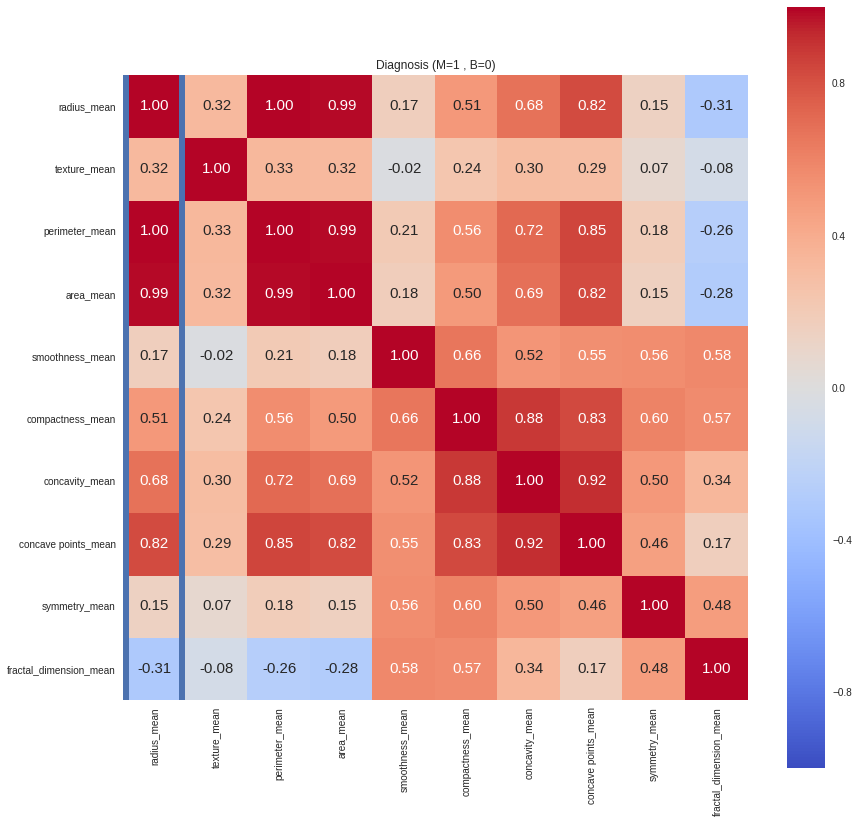

In [10]:
# diagnosis에 대한 히스토그램 작성
plt.hist(df['diagnosis'])
plt.title('Diagnosis (M=1 , B=0)')
plt.show()

In [11]:
# 진단 속성을 두개 속성으로 쪼갠다
dfM=df[df['diagnosis'] ==1]
dfB=df[df['diagnosis'] ==0]

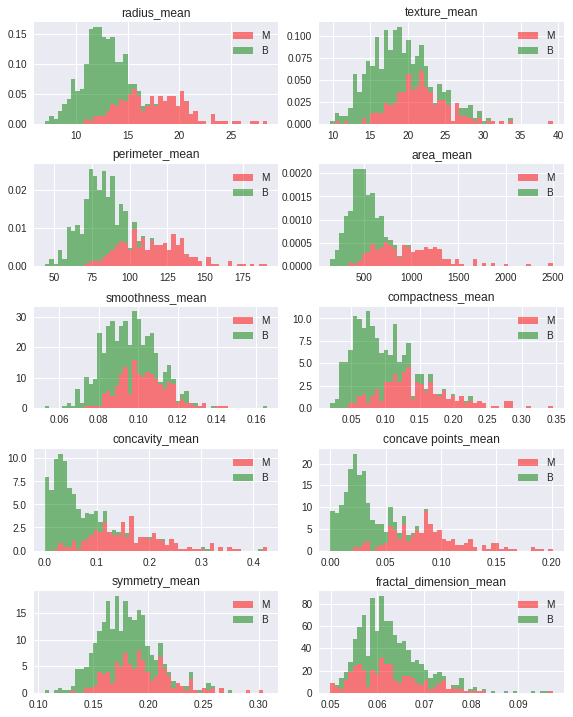

In [12]:
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[features_mean[idx]]) - min(df[features_mean[idx]]))/50
    ax.hist([dfM[features_mean[idx]],dfB[features_mean[idx]]], bins=np.arange(min(df[features_mean[idx]]), max(df[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True, normed = True, label=['M','B'],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

In [13]:
# 트레이닝데이터, 테스트 데이터 분할
traindf, testdf = train_test_split(df, test_size = 0.3)

In [14]:
def classification_model(model, data, predictors, outcome):
    model.fit(data[predictors],data[outcome])
    predictions = model.predict(data[predictors])
  
    # 정확도 출력
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    # 5개의 fold값으로 k-fold cross-validation
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        train_predictors = (data[predictors].iloc[train,:])
        train_target = data[outcome].iloc[train]
        model.fit(train_predictors, train_target)

        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
    model.fit(data[predictors],data[outcome]) 

In [15]:
# Logistic Regression model
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean']
outcome_var='diagnosis'
model=LogisticRegression()
# 모델 평가
classification_model(model,traindf,predictor_var,outcome_var)

Accuracy : 89.196%
Cross-Validation Score : 88.750%
Cross-Validation Score : 90.000%
Cross-Validation Score : 90.000%
Cross-Validation Score : 90.601%
Cross-Validation Score : 89.443%
